# Analiza delovno aktivnega prebivalstva in BDP Slovenije

# Podatki

*[Delovno aktivno prebivalstvo](https://podatki.gov.si/dataset/surs0700992s)*

*[Izdatkovna struktura BDP](https://podatki.gov.si/dataset/surs0301935s?resource_id=8935a064-5888-4ab9-9066-0838f6f2743b)*

In [7]:
from pyaxis import pyaxis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

px_data = pyaxis.parse("./podatki/prebivalstvo.PX", encoding="windows-1250")
data = pd.DataFrame(px_data['DATA'])
data_slovenia = data[data['STATISTIČNA REGIJA'] == 'SLOVENIJA']
data['YEAR'] = data['MESEC'].str[:4]
data['DATA'] = pd.to_numeric(data['DATA'], errors='coerce')
# Izloči zadnje leto
data = data[data['YEAR'] != data['YEAR'].max()]

px_data2 = pyaxis.parse("./podatki/bdp.PX", encoding="windows-1250")
data_bpd = pd.DataFrame(px_data2['DATA'])

Multilingual PX file
Multilingual PX file


## Delovno prebivalstvo v Sloveniji

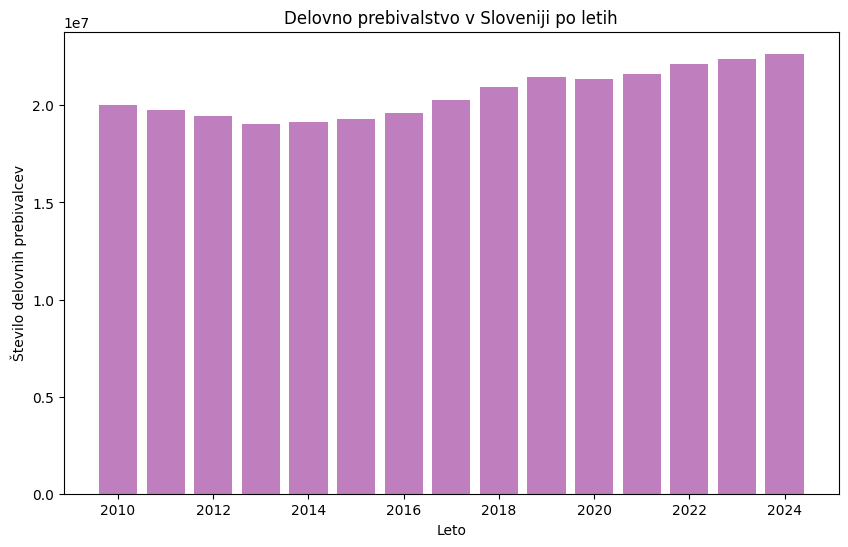

In [8]:
yearly_data = data.groupby('YEAR')['DATA'].sum()
yearly_data.index = pd.to_numeric(yearly_data.index)

plt.figure(figsize=(10, 6))
plt.bar(yearly_data.index, yearly_data.values, color='purple', alpha=0.5)
plt.xlabel('Leto')
plt.ylabel('Število delovnih prebivalcev')
plt.title('Delovno prebivalstvo v Sloveniji po letih')
plt.show()

Graf prikazuje količino delovnega prebivalstva skozi leta. Kot lahko vidimo, se količina počasi povečuje. Leta 2025 ne smemo upoštevati pri naših analizah, saj podatki za celo leto še niso na voljo in zaradi tega niso primerljivi z ostalimi.

## Delovno prebivalstvo glede na starost

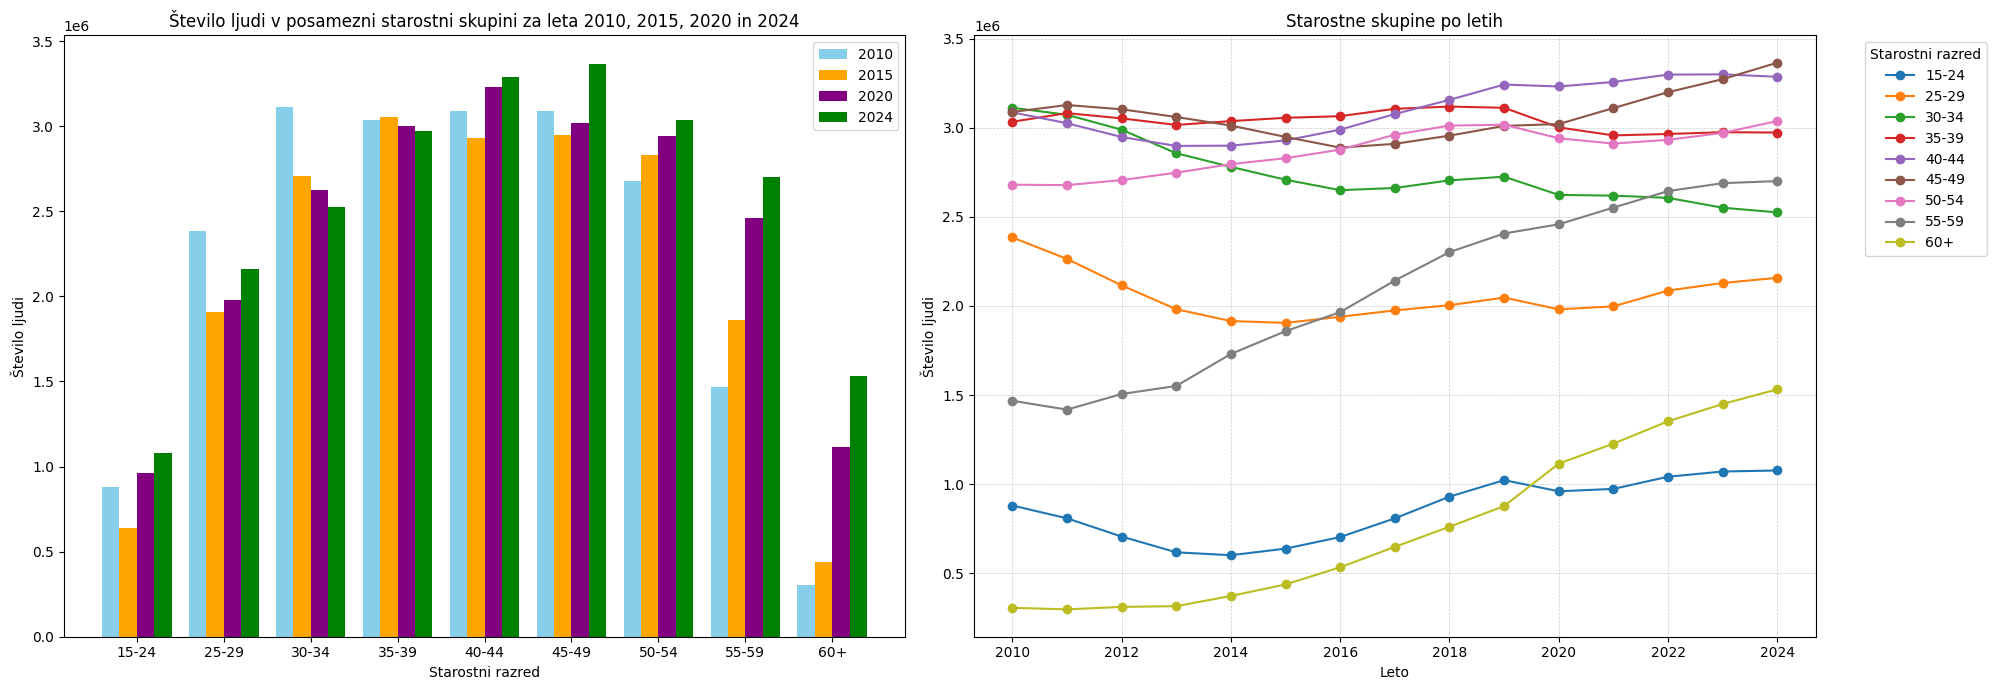

In [9]:
# Nastavi graf z 2 podgrafoma v eni vrstici
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Bar chart
data_2010_age_groups = data[data['YEAR'] == '2010']
data_2015_age_groups = data[data['YEAR'] == '2015']
data_2020_age_groups = data[data['YEAR'] == '2020']
data_2024_age_groups = data[data['YEAR'] == '2024']

age_group_data_2010 = data_2010_age_groups.groupby('STAROSTNI RAZRED')['DATA'].sum()
age_group_data_2015 = data_2015_age_groups.groupby('STAROSTNI RAZRED')['DATA'].sum()
age_group_data_2020 = data_2020_age_groups.groupby('STAROSTNI RAZRED')['DATA'].sum()
age_group_data_2024 = data_2024_age_groups.groupby('STAROSTNI RAZRED')['DATA'].sum()

bar_width = 0.2
x = np.arange(len(age_group_data_2010.index))

axs[0].bar(x - 1.5 * bar_width, age_group_data_2010.values, width=bar_width, color='skyblue', label='2010')
axs[0].bar(x - 0.5 * bar_width, age_group_data_2015.values, width=bar_width, color='orange', label='2015')
axs[0].bar(x + 0.5 * bar_width, age_group_data_2020.values, width=bar_width, color='purple', label='2020')
axs[0].bar(x + 1.5 * bar_width, age_group_data_2024.values, width=bar_width, color='green', label='2024')

axs[0].set_xticks(x)
axs[0].set_xticklabels(age_group_data_2010.index)
axs[0].set_xlabel('Starostni razred')
axs[0].set_ylabel('Število ljudi')
axs[0].set_title('Število ljudi v posamezni starostni skupini za leta 2010, 2015, 2020 in 2024')
axs[0].legend()

# Line chart
grouped = data.groupby(['YEAR', 'STAROSTNI RAZRED'])['DATA'].sum().unstack()
grouped.index = grouped.index.astype(int)
grouped = grouped.sort_index()

for age_group in grouped.columns:
    axs[1].plot(grouped.index, grouped[age_group], marker='o', label=age_group)

axs[1].set_xlabel('Leto')
axs[1].set_ylabel('Število ljudi')
axs[1].set_title('Starostne skupine po letih')
axs[1].legend(title='Starostni razred', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

# Prikaz
plt.tight_layout()
plt.show()

Iz grafa je razvidno, da je skozi leta vse več ljudi v starostni skupini 50+, ki so še del delovnega prebivalstva. Eden od glavnih razlogov za to, je verjetno staranje prebivalstva in daljšanje življenske dobe. Zaradi napredka medicine, pa je starejšim ljudem tudi vse lažje delati, saj je veliko bolezni, ki bi poslabšale kvaliteto življenja ali znižale življensko dobo, vse bolj ozdravljivih.

<Figure size 1000x600 with 0 Axes>

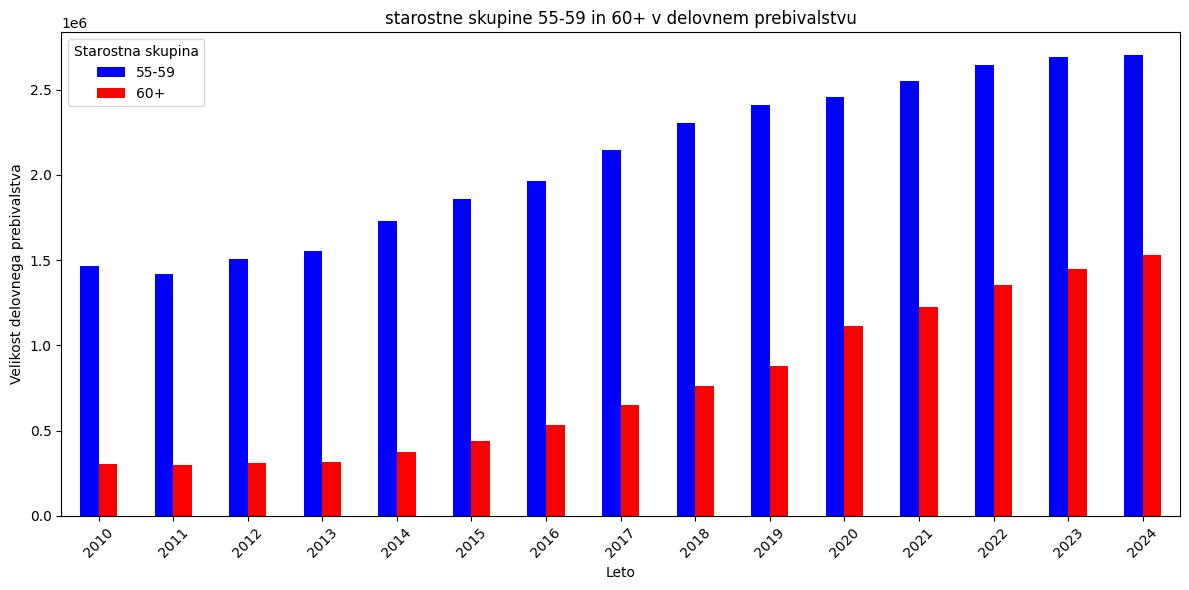

In [10]:
age_groups = data[data['STAROSTNI RAZRED'].isin(['55-59', '60+'])]

age_group_yearly_data = age_groups.groupby(['YEAR', 'STAROSTNI RAZRED'])['DATA'].sum().unstack()

plt.figure(figsize=(10, 6))
age_group_yearly_data.plot(kind='bar', stacked=False, figsize=(12, 6), color=['blue', 'red'])
plt.xlabel('Leto')
plt.ylabel('Velikost delovnega prebivalstva')
plt.title('starostne skupine 55-59 in 60+ v delovnem prebivalstvu')
plt.legend(title='Starostna skupina')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

S tem grafom si lahko potrdimo, da ima delovno prebivalstvo vedno več ljudi v starostni skupini 55+, kar kaže na to, da se delovna sila povečuje tudi pri starejših ljudeh, zaradi prej omenjenih razlogov, ne pa samo mlajših.

# Struktura delovnega prebivalstva po regijah

## Število delovnih prebivalcev glede na regijo

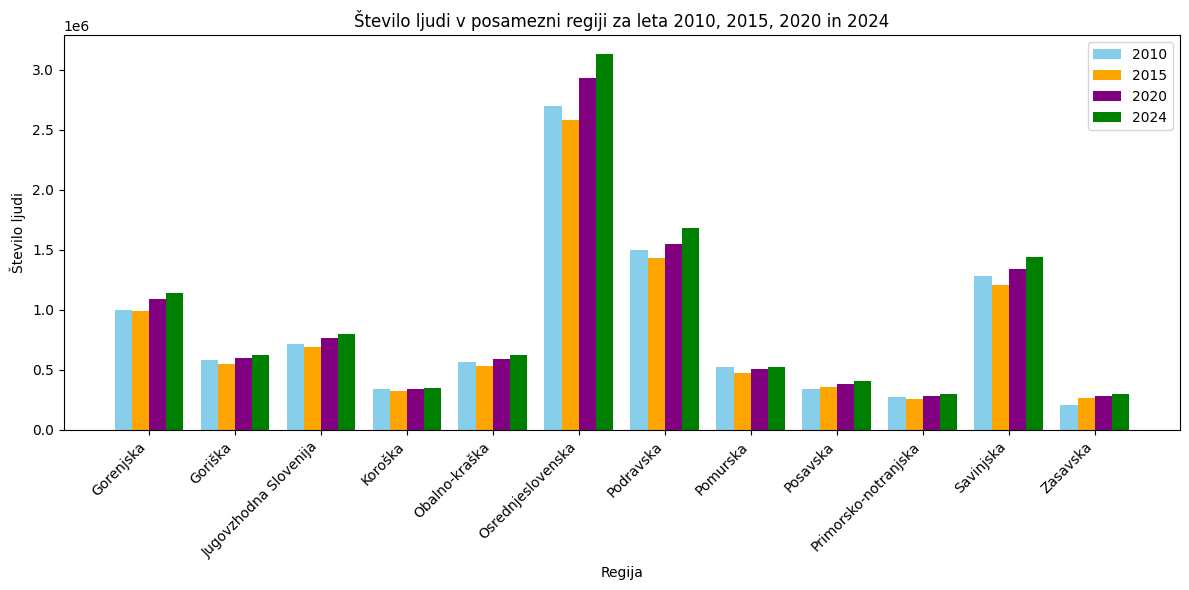

In [11]:
data_2010_regions = data[data['YEAR'] == '2010']
data_2015_regions = data[data['YEAR'] == '2015']
data_2020_regions = data[data['YEAR'] == '2020']
data_2024_regions = data[data['YEAR'] == '2024']

region_data_2010 = data_2010_regions[data_2010_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].sum()
region_data_2015 = data_2015_regions[data_2015_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].sum()
region_data_2020 = data_2020_regions[data_2020_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].sum()
region_data_2024 = data_2024_regions[data_2024_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].sum()

plt.figure(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(region_data_2010.index))

plt.bar(x - 1.5 * bar_width, region_data_2010.values, width=bar_width, color='skyblue', label='2010')
plt.bar(x - 0.5 * bar_width, region_data_2015.values, width=bar_width, color='orange', label='2015')
plt.bar(x + 0.5 * bar_width, region_data_2020.values, width=bar_width, color='purple', label='2020')
plt.bar(x + 1.5 * bar_width, region_data_2024.values, width=bar_width, color='green', label='2024')

plt.xticks(x, region_data_2010.index, rotation=45, ha='right')
plt.xlabel('Regija')
plt.ylabel('Število ljudi')
plt.title('Število ljudi v posamezni regiji za leta 2010, 2015, 2020 in 2024')
plt.legend()
plt.tight_layout()
plt.show()

V vseh regijah se količina delovnega prebivalstva razvija zelo podobno. Najbolj izstopata Osrednjeslovenska in Koroška regija. V osrednjeslovenski regiji lahko vidimo, da je rast delovnega prebivalstva večja, kot pri drugih regijah. To bi lahko pripisali temu, da ima ta regija največjo rast prebivalstva, saj je osrednja regija države, ljudje pa se večinoma preseljujejo iz podeželja v mesta in ne obratno.

Večinoma se vidijo razlike med regijami z več mesti in tistimi z manj. Največjo rast imajo Osrednjeslovenska, Podravska in Savinjska regija. Te regije imajo veliko mest in manj podeželjskih področij. Če pa pogledamo na regije, kjer delavno prebivalstvo raste počasneje, kot so Koroška, Primorsko-notranjska in Posavska, pa lahko vidimo, da so to manj urbanizirane regije v državi.

# Vpliv COVID-19 na delovno prebivalstvo

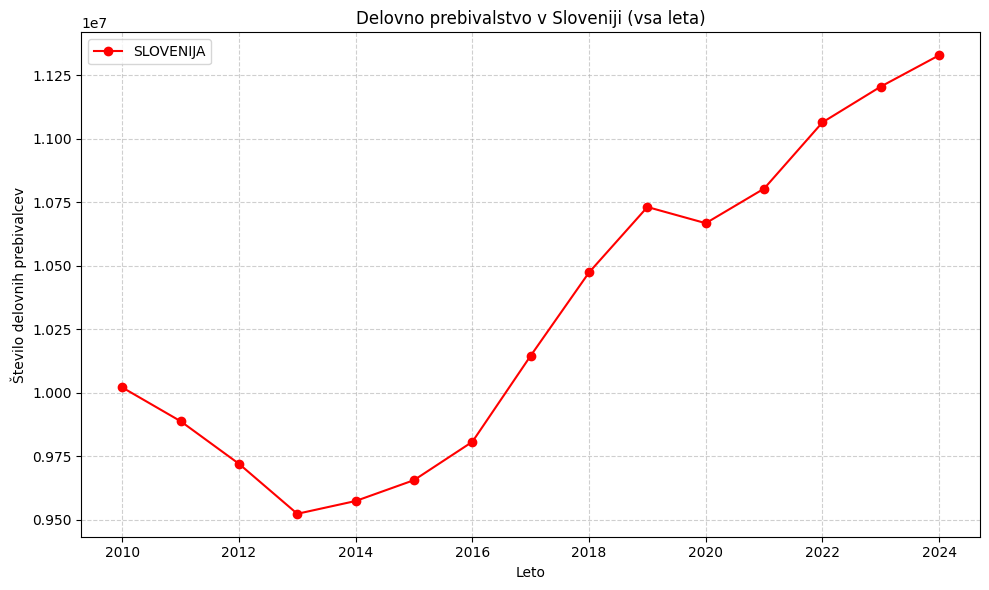

In [12]:
data_covid_years = data[data['STATISTIČNA REGIJA'] == 'SLOVENIJA']
covid_yearly_data = data_covid_years.groupby('YEAR')['DATA'].sum()
covid_yearly_data.index = pd.to_numeric(covid_yearly_data.index)

plt.figure(figsize=(10, 6))
plt.plot(covid_yearly_data.index, covid_yearly_data.values, marker='o', color='red', label='SLOVENIJA')
plt.xlabel('Leto')
plt.ylabel('Število delovnih prebivalcev')
plt.title('Delovno prebivalstvo v Sloveniji (vsa leta)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Na grafu se jasno vidi, kako upadanje delovnega prebivalstva sovpada z finančnimi krizami. Prvi vidni upad je viden od leta 2010 do leta 2013, kar se sklada s finančno kriza, ki je trajala od 2008 do 2013. Za tem obdobjem vidimo, da se števnost delovnega prebivalstva izrazito povečuje vse do leta 2019. Na koncu tega leta se je začela pandemija COVID-19, kar je očitno imelo vpliv na zaposlenost. Vidimo lahko, da je imela pandemija veliko manjši vpliv na zaposlenost kot finančna kriza, saj je upadanje števila zaposlenih manj strmo. Zanimivo je tudi, da je imel vpliv samo začetek pandemije, torej prvo leto, ne pa celotno obdobje, ki je trajalo vse do leta 2023. Pri finančni krizi lahko vidimo velik vpliv vse do konca krize (leto 2013), nato pa počasno opomoranje, medtem ko se je delovna sila po vplivu pandemije veliko hitreje opomogla. Razlog za to je bil verjetno tudi razvoj dela od doma, ki je pomagal ohraniti službe, ki bi v preteklosti zaradi izolacije morda propadle.